In [1]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
plt.style.use('dark_background')

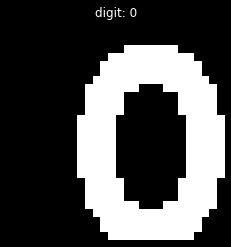

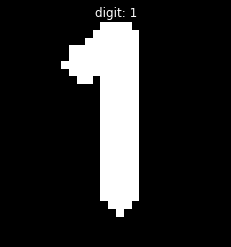

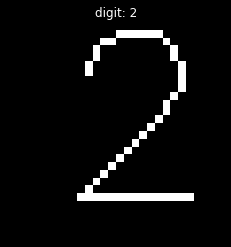

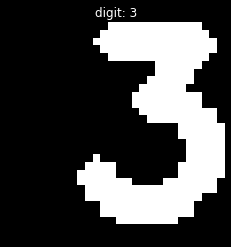

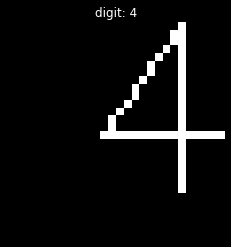

In [2]:
def generate_digit_image(digit):
    text = '%d' % digit
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_size = 1
    font_color = 255
    thickness = np.random.randint(1, 4)
    text_size = cv2.getTextSize(text, font, font_size, thickness)[0]
    image = np.zeros((28, 28), dtype = np.uint8)
    loc = (np.random.randint(-3, 11), np.random.randint(21, 28))
    image = cv2.putText(image, text, loc, font, font_size, font_color, thickness)
    return image

for digit in range(5):
    image = generate_digit_image(digit)
    plt.imshow(image, cmap='gray')
    plt.title('digit: %d' % digit)
    plt.axis('off')
    plt.show()

In [3]:
n_digits = 5
n_train_per_class = 1000
n_test_per_class = 100

for digit in range(n_digits):
    print(digit)
    print('generating train')
    for i_sample in range(n_train_per_class):
        image = generate_digit_image(digit)
        cv2.imwrite('SiameseCNN_Dataset/train/Image_%d_%05d.png' % (digit, i_sample), image)
    print('generating test')
    for i_sample in range(n_test_per_class):
        image = generate_digit_image(digit)
        cv2.imwrite('SiameseCNN_Dataset/test/Image_%d_%05d.png' % (digit, i_sample), image)

0
generating train
generating test
1
generating train
generating test
2
generating train
generating test
3
generating train
generating test
4
generating train
generating test


In [4]:
im_size = 28
n_channels = 1

def get_batch(n, phase='train'):
    n_categories = n_digits
    if phase == 'train':
        data_path = 'SiameseCNN_Dataset/train'
        n_imgs_per_category = n_train_per_class
    elif phase == 'test':
        data_path = 'SiameseCNN_Dataset/test'
        n_imgs_per_category = n_test_per_class
    
    a_batch = np.zeros((n, n_channels, im_size, im_size))
    b_batch = np.zeros((n, n_channels, im_size, im_size))
    y_batch = np.zeros((n, ))
    for j in range(n//2):
        # same category
        category = np.random.randint(n_categories)
        ind_a = np.random.randint(n_imgs_per_category)
        ind_b = np.random.randint(n_imgs_per_category)
        im_a = io.imread('%s/Image_%d_%05d.png' % (data_path, category, ind_a)).astype('double')/255
        im_b = io.imread('%s/Image_%d_%05d.png' % (data_path, category, ind_b)).astype('double')/255

        a_batch[2*j,:,:,:] = np.expand_dims(im_a, 0)
        b_batch[2*j,:,:,:] = np.expand_dims(im_b, 0)
        y_batch[2*j] = 0

        # diff categories
        category_a = np.random.randint(n_categories)
        category_b = category_a
        while category_b == category_a:
            category_b = np.random.randint(n_categories)
        ind_a = np.random.randint(n_imgs_per_category)
        ind_b = np.random.randint(n_imgs_per_category)
        im_a = io.imread('%s/Image_%d_%05d.png' % (data_path, category_a, ind_a)).astype('double')/255
        im_b = io.imread('%s/Image_%d_%05d.png' % (data_path, category_b, ind_b)).astype('double')/255

        a_batch[2*j+1,:,:,:] = np.expand_dims(im_a, 0)
        b_batch[2*j+1,:,:,:] = np.expand_dims(im_b, 0)
        y_batch[2*j+1] = 1

    return a_batch, b_batch, y_batch

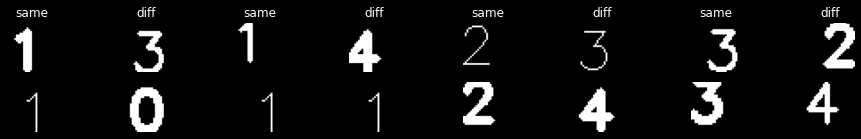

In [5]:
n = 8
A, B, Y = get_batch(n)

fig = plt.figure(figsize=(2*n,2))
for i in range(n):
    im_a, im_b, y = np.mean(A[i,:,:,:], axis=0), np.mean(B[i,:,:,:], axis=0), Y[i]
    plt.subplot(2, n, 1+i)
    plt.imshow(im_a, cmap='gray'); plt.axis('off')
    plt.title('same' if y == 0 else 'diff')
    plt.subplot(2, n, n+1+i)
    plt.imshow(im_b, cmap='gray'); plt.axis('off')
plt.show()

In [6]:
embed_dim = 64

class CNNBranch(nn.Module):
    def __init__(self):
        super(CNNBranch, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 6, 5) # n chan in, n chan out, kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, embed_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn_branch = CNNBranch()
A, B, Y = get_batch(n)
A, B, Y = torch.from_numpy(A).float(), torch.from_numpy(B).float(), torch.from_numpy(Y).long()
print(A.shape, B.shape, Y.shape)
print(cnn_branch(A).shape, cnn_branch(B).shape)

torch.Size([8, 1, 28, 28]) torch.Size([8, 1, 28, 28]) torch.Size([8])
torch.Size([8, 64]) torch.Size([8, 64])


In [7]:
n_classes = 2

class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.cnn_branch = CNNBranch()
        self.fc = nn.Linear(embed_dim, n_classes)

    def forward(self, x_a, x_b):
        embed_a = self.cnn_branch(x_a)
        embed_b = self.cnn_branch(x_b)
        merge = torch.abs(torch.sub(embed_a, embed_b))
        return self.fc(merge)
    
siamese_net = SiameseNet()
prediction = siamese_net(A, B)
print(prediction.shape, Y.shape)

torch.Size([8, 2]) torch.Size([8])


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(siamese_net.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [9]:
n_steps = 5000

siamese_net.to(device)
criterion.to(device)
losses = []
for i_step in range(n_steps):
    A, B, Y = get_batch(n)
    A = torch.from_numpy(A).float().to(device)
    B = torch.from_numpy(B).float().to(device)
    Y = torch.from_numpy(Y).long().to(device)

    optimizer.zero_grad()

    prediction = siamese_net(A, B)
    loss = criterion(prediction, Y)
    loss.backward()
    optimizer.step()

    if len(losses) == 0:
        losses.append(loss.item())
    else:
        losses.append(0.5*losses[-1]+0.5*loss.item())
    if i_step % 1000 == 999:
        print('step', i_step+1, 'loss', losses[-1])

step 1000 loss 0.6878210477490576
step 2000 loss 0.6502586720862691
step 3000 loss 0.3703302723731394
step 4000 loss 0.05872782669031942
step 5000 loss 0.01908171827013775


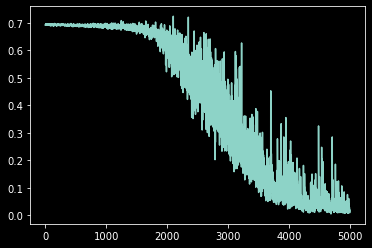

In [10]:
plt.plot(losses)
plt.show()

In [11]:
correct = 0
total = 0

n_batches = 100
with torch.no_grad():
    for i_batch in range(n_batches):
        A, B, Y = get_batch(n, 'test')
        A = torch.from_numpy(A).float().to(device)
        B = torch.from_numpy(B).float().to(device)
        Y = torch.from_numpy(Y).long().to(device)
        prediction = siamese_net(A, B)
        mx, imx = torch.max(prediction,1)
        total += len(Y)
        correct += (imx == Y).sum().item()
    
print('accuracy', correct / total)

accuracy 1.0


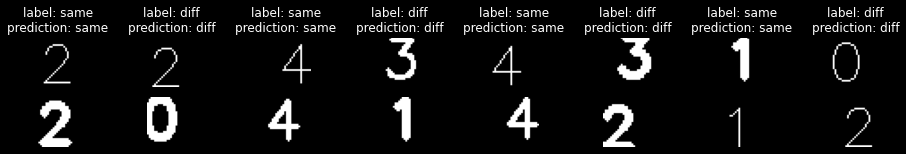

In [12]:
with torch.no_grad():
    A, B, Y = get_batch(n, 'test')
    pt_A = torch.from_numpy(A).float().to(device)
    pt_B = torch.from_numpy(B).float().to(device)
    prediction = siamese_net(pt_A, pt_B)
    mx, imx = torch.max(prediction,1)
    imx = imx.numpy().tolist()
    
    fig = plt.figure(figsize=(2*n,2))
    for i in range(n):
        im_a, im_b, y = np.mean(A[i,:,:,:], axis=0), np.mean(B[i,:,:,:], axis=0), Y[i]
        plt.subplot(2, n, 1+i)
        plt.imshow(im_a, cmap='gray'); plt.axis('off')
        t0 = 'label: same' if y == 0 else 'label: diff'
        t1 = 'prediction: same' if imx[i] == 0 else 'prediction: diff'
        plt.title(t0+'\n'+t1)
        plt.subplot(2, n, n+1+i)
        plt.imshow(im_b, cmap='gray'); plt.axis('off')
    plt.show()